# Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import folium
from folium.plugins import HeatMap
import plotly.express as px

# Combining all dataset of all months

In [2]:
df_april = pd.read_csv(r'C:\Users\ADMIN\Python\Ml projects\Uber Analysis\Dataset\uber-raw-data-apr14.csv')
df_may = pd.read_csv(r'C:\Users\ADMIN\Python\Ml projects\Uber Analysis\Dataset\uber-raw-data-may14.csv')
df_june = pd.read_csv(r'C:\Users\ADMIN\Python\Ml projects\Uber Analysis\Dataset\uber-raw-data-jun14.csv')
df_july = pd.read_csv(r'C:\Users\ADMIN\Python\Ml projects\Uber Analysis\Dataset\uber-raw-data-jul14.csv')
df_aug = pd.read_csv(r'C:\Users\ADMIN\Python\Ml projects\Uber Analysis\Dataset\uber-raw-data-aug14.csv')
df_sept = pd.read_csv(r'C:\Users\ADMIN\Python\Ml projects\Uber Analysis\Dataset\uber-raw-data-sep14.csv')

# Concatenating Files Apr-Sept, 2014
uber_data = pd.concat ([df_april, df_may, df_june, df_july, df_aug, df_sept], axis=0)

# Preprocessing and Feature engineering 

In [3]:
uber_data['Date/Time'] = pd.to_datetime(uber_data['Date/Time'], format="%m/%d/%Y %H:%M:%S")
uber_data['DayOfWeekNum'] = uber_data['Date/Time'].dt.dayofweek
uber_data['DayOfWeek'] = uber_data['Date/Time'].dt.day_name()
uber_data['MonthDayNum'] = uber_data['Date/Time'].dt.day
uber_data['HourOfDay'] = uber_data['Date/Time'].dt.hour

# adding columns to do monthly analysis
uber_data['Month_name'] = uber_data['Date/Time'].dt.month_name()
uber_data['Month_no.'] = uber_data['Date/Time'].dt.month

In [4]:
uber_data.head()

,Date/Time,Lat,Lon,Base,DayOfWeekNum,DayOfWeek,MonthDayNum,HourOfDay,Month_name,Month_no.
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,1,Tuesday,1,0,April,4
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,1,Tuesday,1,0,April,4
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,1,Tuesday,1,0,April,4
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,1,Tuesday,1,0,April,4
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,1,Tuesday,1,0,April,4


# Visualization on a Journeys by Days of week

In [5]:
weekday = pd.DataFrame(uber_data[['Month_no.', 'DayOfWeekNum']].value_counts()).reset_index()
weekday = weekday.sort_values(by = ['Month_no.', 'DayOfWeekNum'], ascending = [True, True])
weekday.rename(columns={'Month_no.' : 'Month',  'DayOfWeekNum' : 'WeekDay', 0 : 'Count'}, inplace = True)

fig_1 = px.bar(weekday, x='WeekDay', y='Count', color='Month',
      template='plotly_dark',
      labels={'Count':'Number of Trips','WeekDay':'Day of the Week'},
      category_orders={"Month": [4,5,6,7,8,9]},
    text='Count')
fig_1.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig_1.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig_1.update_layout(title_text='Uber pick-ups by Months and Weekdays', title_x=0.5)
fig_1.show()

# Visualization on a Journeys in a Month

In [6]:
month_day = pd.DataFrame(uber_data[['Month_no.', 'MonthDayNum']].value_counts()).reset_index()
month_day = month_day.sort_values(by = ['Month_no.', 'MonthDayNum'], ascending = [True, True])
month_day.rename(columns={'Month_no.' : 'Month',  'MonthDayNum' : 'Day', 0 : 'Count'}, inplace = True)

fig_2 = px.bar(month_day, x='Day', y='Count', color='Month',
      template='plotly_dark',
      labels={'Count':'Number of Trips','Day':'Day of the Month'},
      category_orders={"Month": [4,5,6,7,8,9]},
    text='Count')
fig_2.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig_2.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig_2.update_layout(title_text='Uber pick-ups by Months and Days', title_x=0.5)
fig_2.show()

# Cross Analysis between hours and weekdays

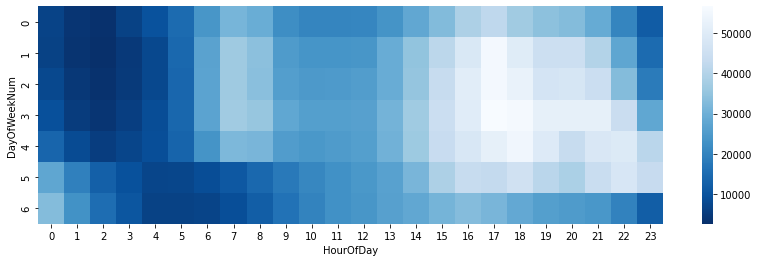

In [7]:
hour_week = uber_data.groupby(['DayOfWeekNum','HourOfDay']).count()['Date/Time']
pivot = hour_week.unstack()

plt.figure(figsize = (14,4))
fig_3 = sns.heatmap(pivot, cmap = 'Blues_r')

# Visualization on a Journeys in each Month (June - Dec' 14)

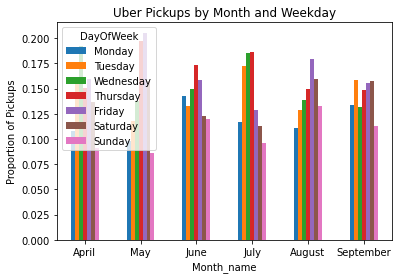

In [8]:
month_map = {
    4: 'April',
    5: 'May',
    6: 'June', 
    7: 'July',
    8: 'August',
    9: 'September'
}

weekday_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday', 
    4: 'Friday', 
    5: 'Saturday',
    6: 'Sunday'
}


monthly_weekdays = uber_data.groupby('Month_name')['DayOfWeek'].value_counts().unstack()
monthly_weekdays_norm = monthly_weekdays.apply(lambda x: x/x.sum(), axis=1)

monthly_weekdays_norm.loc[month_map.values(),weekday_map.values()].plot(kind='bar', rot=0)
plt.ylabel('Proportion of Pickups')
plt.title('Uber Pickups by Month and Weekday');

# Visualization on a Map

In [9]:
uber_data['Lat'] = uber_data['Lat'].apply(lambda x: int(x * 1000) / 1000)
uber_data['Lon'] = uber_data['Lon'].apply(lambda x: int(x * 1000) / 1000)
uber_location = uber_data[['Lat', 'Lon']]
duplicate_locations = uber_location[uber_location.duplicated()]
uber_location_count = duplicate_locations.groupby(['Lat', 'Lon']).size().rename('count').to_frame().reset_index()

base = folium.Map(location=[40.8, -73.6], zoom_start=8)
HeatMap(uber_location_count, radius=15).add_to(base)
base

# Top 5 pickup locations

In [10]:
uber_top5 = uber_location_count.nlargest(5, 'count')
uber_top5 = uber_top5.reset_index()

m = folium.Map(location=[40.7, -73.9], tiles="OpenStreetMap", zoom_start=11)

for i in range(0,len(uber_top5)):
    folium.Marker(
       location=[uber_top5.iloc[i]['Lat'], uber_top5.iloc[i]['Lon']],
       popup=uber_top5.iloc[i],
    ).add_to(m)
    
m

# Hourly analysis of Top 5 pickup locations

In [12]:
def add_trailing_zeros(x, n):
  return '{:.{}f}'.format(x, n)
  
uber_data = uber_data.assign(col1=uber_data['Lat'].apply(add_trailing_zeros, n=3), col2=uber_data['Lon'].apply(add_trailing_zeros, n=3))

In [13]:
uber_data.head()

,Date/Time,Lat,Lon,Base,DayOfWeekNum,DayOfWeek,MonthDayNum,HourOfDay,Month_name,Month_no.,col1,col2
0,2014-04-01 00:11:00,40.769,-73.954,B02512,1,Tuesday,1,0,April,4,40.769,-73.954
1,2014-04-01 00:17:00,40.726,-74.034,B02512,1,Tuesday,1,0,April,4,40.726,-74.034
2,2014-04-01 00:21:00,40.731,-73.987,B02512,1,Tuesday,1,0,April,4,40.731,-73.987
3,2014-04-01 00:28:00,40.758,-73.977,B02512,1,Tuesday,1,0,April,4,40.758,-73.977
4,2014-04-01 00:33:00,40.759,-73.972,B02512,1,Tuesday,1,0,April,4,40.759,-73.972
...,...,...,...,...,...,...,...,...,...,...,...,...
1028131,2014-09-30 22:57:00,40.766,-73.984,B02764,1,Tuesday,30,22,September,9,40.766,-73.984
1028132,2014-09-30 22:57:00,40.691,-74.177,B02764,1,Tuesday,30,22,September,9,40.691,-74.177
1028133,2014-09-30 22:58:00,40.851,-73.931,B02764,1,Tuesday,30,22,September,9,40.851,-73.931
1028134,2014-09-30 22:58:00,40.708,-74.006,B02764,1,Tuesday,30,22,September,9,40.708,-74.006


In [14]:
uber_data['location'] = uber_data[['col1', 'col2']].apply(lambda x: ', '.join(map(str, x)), axis=1)

In [15]:
duplicates = uber_data.duplicated(subset='location').groupby(uber_data['location']).sum().to_frame().reset_index()
duplicates = duplicates.sort_values(by = [0], ascending = False).head()

In [16]:
specific_rows = uber_data.loc[uber_data['location'].isin(['40.644, -73.782', '40.774, -73.872', '40.768, -73.862', '40.740, -74.005', '40.646, -73.789'])]
specific_rows = specific_rows.sort_values(by = 'HourOfDay')
specific_rows

,Date/Time,Lat,Lon,Base,DayOfWeekNum,DayOfWeek,MonthDayNum,HourOfDay,Month_name,Month_no.,col1,col2,location
187724,2014-07-21 00:07:00,40.644,-73.782,B02598,0,Monday,21,0,July,7,40.644,-73.782,"40.644, -73.782"
433592,2014-09-13 00:38:00,40.740,-74.005,B02617,5,Saturday,13,0,September,9,40.740,-74.005,"40.740, -74.005"
433483,2014-09-13 00:27:00,40.740,-74.005,B02617,5,Saturday,13,0,September,9,40.740,-74.005,"40.740, -74.005"
433437,2014-09-13 00:22:00,40.740,-74.005,B02617,5,Saturday,13,0,September,9,40.740,-74.005,"40.740, -74.005"
433367,2014-09-13 00:17:00,40.740,-74.005,B02617,5,Saturday,13,0,September,9,40.740,-74.005,"40.740, -74.005"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
601251,2014-06-21 23:27:00,40.774,-73.872,B02682,5,Saturday,21,23,June,6,40.774,-73.872,"40.774, -73.872"
601273,2014-06-21 23:29:00,40.740,-74.005,B02682,5,Saturday,21,23,June,6,40.740,-74.005,"40.740, -74.005"
601425,2014-06-21 23:53:00,40.740,-74.005,B02682,5,Saturday,21,23,June,6,40.740,-74.005,"40.740, -74.005"
673478,2014-08-11 23:54:00,40.740,-74.005,B02682,0,Monday,11,23,August,8,40.740,-74.005,"40.740, -74.005"


Text(0.5, 1.0, 'Journeys by Hour in top 5 pickup locations')

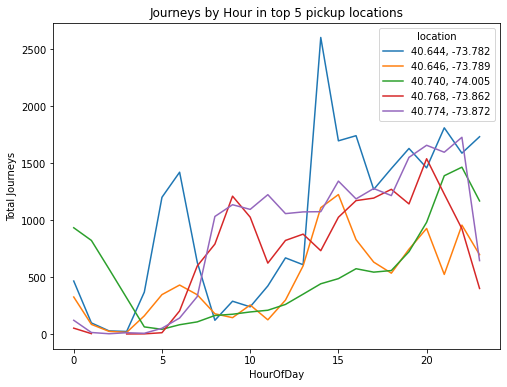

In [17]:
p = specific_rows.groupby(['location','HourOfDay']).count().unstack('location')['Date/Time'].plot(figsize = (8,6))
plt.ylabel('Total Journeys')
plt.title('Journeys by Hour in top 5 pickup locations')

# Visualization of Journeys by Month by Dispatch Base 

Text(0.5, 1.0, 'Journeys by Month by Dispatch Base')

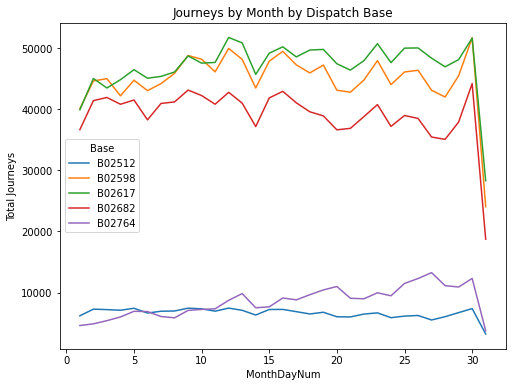

In [11]:
uber_data.groupby(['Base','MonthDayNum']).count().unstack('Base')['Date/Time'].plot(figsize = (8,6))
plt.ylabel('Total Journeys')
plt.title('Journeys by Month by Dispatch Base')